In [1]:
import sys
sys.path.append("../..")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
%matplotlib inline

In [2]:
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from new_train import train_nis
from new_train import train_nisp_rnis
from nis_net import NISNet
from nis_net import NISPNet
from nis_net import RNISNet
from datetime import datetime
from new_kuramoto import KuramotoModel
t0 = datetime.now()


use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0') if use_cuda else torch.device('cpu')
device

device(type='cuda', index=0)

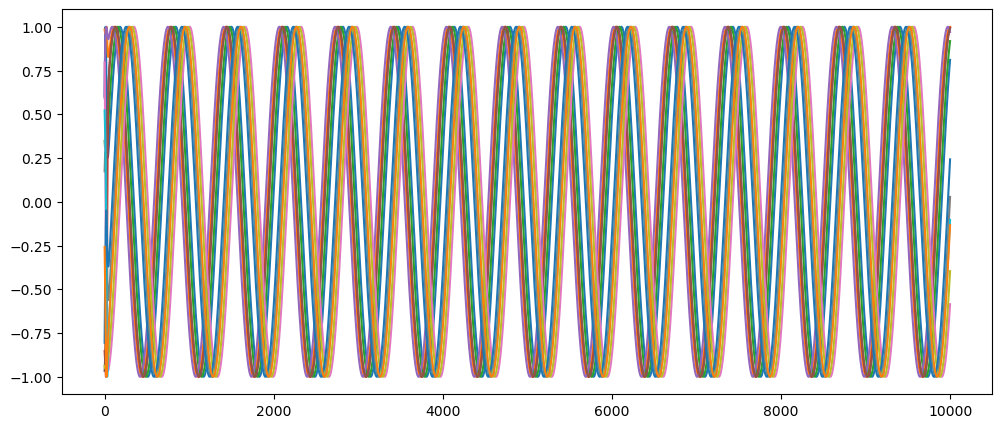

In [6]:
seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

kura_train = KuramotoModel(steps=10000, dt=0.01, sz=6, groups=1, coupling=0.5)
timeserie, timeserie_next, _, _ = kura_train.simulate_oneserie(sample_step=5)

plt.figure(figsize=(12,5))
for i in range(12):
    plt.plot(timeserie[:,i])
plt.show()

In [7]:
seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

kur_train = KuramotoModel(steps=10000, dt=0.01, sz=6, groups=2, coupling=0.5, sample_step=5)
kur_test = KuramotoModel(steps=1000, dt=0.01, sz=6, groups=2, coupling=0.5, sample_step=5)
train_data = [torch.FloatTensor(kur_train.input).to(device), torch.FloatTensor(kur_train.output).to(device)]
test_data = [torch.FloatTensor(kur_test.input).to(device), torch.FloatTensor(kur_test.output).to(device)]

# Train

In [9]:
# train params

T_total = 20001
clip = 500
sz = 12
scale = 4
hidden_units = 64
batch_size = 128
mae2_w = 3

# RNIS

In [10]:
seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
net_rnis = RNISNet(input_size=sz, latent_size=scale, output_size=sz, 
                        hidden_units=hidden_units, hidden_units_dyn=32,
                        is_normalized=True)
trainer = train_nisp_rnis(net=net_rnis, data=train_data, data_test=test_data, device=device)
trainer.training(T1=3000, T_all=T_total, mae2_w=mae2_w, batch_size=batch_size, clip=clip)
eis_rnis, term1s_rnis, term2s_rnis, losses_rnis, MAEs_mstep_rnis = trainer.return_log()
param_counts_rnis = trainer.param_counts

check point------step-> 11:16:44.778183; lasting 0:03:23.048729 seconds
Epoch: 0
Train loss: 0.0015
Test loss: 0.7361
dEI: 0.0875
term1: -2.2836
term2: 2.6335
------------------------------------------------------------------------------------------------------------------------
check point------step-> 11:17:06.299666; lasting 0:00:21.521483 seconds
Epoch: 500
Train loss: 0.5459
Test loss: 0.4956
dEI: 0.9265
term1: 0.3145
term2: 3.3916
------------------------------------------------------------------------------------------------------------------------
check point------step-> 11:17:27.654505; lasting 0:00:21.354839 seconds
Epoch: 1000
Train loss: 0.3863
Test loss: 0.5286
dEI: 1.0699
term1: 0.8079
term2: 3.4718
------------------------------------------------------------------------------------------------------------------------
check point------step-> 11:17:48.659744; lasting 0:00:21.005239 seconds
Epoch: 1500
Train loss: 0.3191
Test loss: 0.5356
dEI: 1.2289
term1: 1.6000
term2: 3.3

# NIS

In [11]:
seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
net_nis = NISNet(input_size=sz, latent_size=scale, output_size=sz, 
                        hidden_units=hidden_units, is_normalized=True)
trainer = train_nis(net=net_nis, data=train_data, data_test=test_data, device=device)
trainer.training(T_all=T_total, batch_size=batch_size, clip=clip)
eis_nis, term1s_nis, term2s_nis, losses_nis, MAEs_mstep_nis = trainer.return_log()
param_counts_nis = trainer.param_counts

check point------step-> 11:31:11.746034; lasting 0:00:06.740288 seconds
Epoch: 0
Train loss: 0.0014
Test loss: 0.6904
dEI: 0.3749
term1: -1.2322
term2: 2.7316
------------------------------------------------------------------------------------------------------------------------
check point------step-> 11:31:27.897957; lasting 0:00:16.151923 seconds
Epoch: 500
Train loss: 0.5274
Test loss: 0.4972
dEI: 1.1562
term1: 1.3902
term2: 3.2344
------------------------------------------------------------------------------------------------------------------------
check point------step-> 11:31:45.164623; lasting 0:00:17.266666 seconds
Epoch: 1000
Train loss: 0.3866
Test loss: 0.5198
dEI: 1.2378
term1: 1.5724
term2: 3.3787
------------------------------------------------------------------------------------------------------------------------
check point------step-> 11:32:02.481896; lasting 0:00:17.317273 seconds
Epoch: 1500
Train loss: 0.3190
Test loss: 0.5342
dEI: 1.2930
term1: 1.8998
term2: 3.2

# NIS+

In [12]:
seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
net_nisp = NISPNet(input_size=sz, latent_size=scale, output_size=sz, 
                        hidden_units=hidden_units, hidden_units_dyn=hidden_units,
                        is_normalized=True)
trainer = train_nisp_rnis(net=net_nisp, data=train_data, data_test=test_data, device=device)
trainer.training(T1=3000, T_all=T_total, mae2_w=mae2_w, batch_size=batch_size, clip=clip)
eis_nisp, term1s_nisp, term2s_nisp, losses_nisp, MAEs_mstep_nisp = trainer.return_log()
param_counts_nisp = trainer.param_counts

check point------step-> 11:42:19.008543; lasting 0:00:02.403824 seconds
Epoch: 0
Train loss: 0.0014
Test loss: 0.6904
dEI: 0.3749
term1: -1.2322
term2: 2.7316
------------------------------------------------------------------------------------------------------------------------
check point------step-> 11:42:33.831183; lasting 0:00:14.822640 seconds
Epoch: 500
Train loss: 0.5274
Test loss: 0.4972
dEI: 1.1562
term1: 1.3902
term2: 3.2344
------------------------------------------------------------------------------------------------------------------------
check point------step-> 11:42:49.325111; lasting 0:00:15.493928 seconds
Epoch: 1000
Train loss: 0.3866
Test loss: 0.5198
dEI: 1.2378
term1: 1.5724
term2: 3.3787
------------------------------------------------------------------------------------------------------------------------
check point------step-> 11:42:59.620623; lasting 0:00:10.295512 seconds
Epoch: 1500
Train loss: 0.3190
Test loss: 0.5342
dEI: 1.2930
term1: 1.8998
term2: 3.2

# Result

In [13]:
print(param_counts_nis, param_counts_nisp, param_counts_rnis)

39372 44112 40024


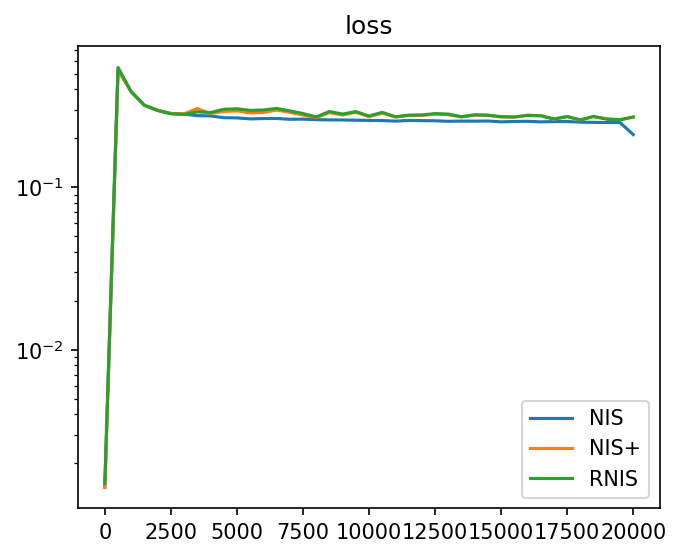

In [15]:
plt.figure(figsize=(5,4),dpi=150)
timeseries = np.arange(len(eis_nis)) * clip
plt.plot(timeseries, losses_nis, label='NIS')
timeseries = np.arange(len(losses_nisp)) * clip
plt.plot(timeseries, losses_nisp, label='NIS+')
timeseries = np.arange(len(losses_rnis)) * clip
plt.plot(timeseries, losses_rnis, label='RNIS')
plt.title(r'loss')
plt.legend()
plt.yscale('log')
plt.show()

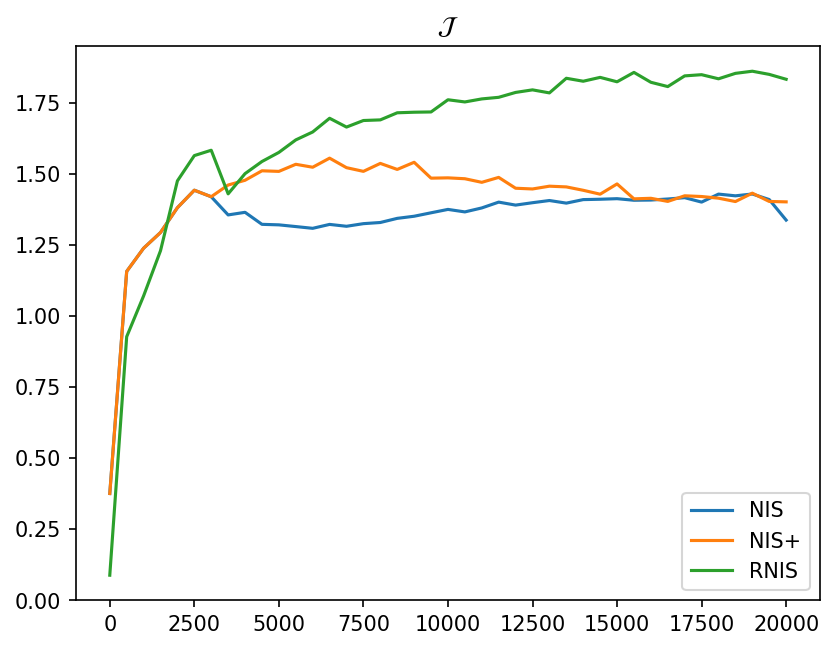

In [16]:
plt.figure(dpi=150)
timeseries = np.arange(len(eis_nis)) * clip
plt.plot(timeseries, eis_nis, label='NIS')
timeseries = np.arange(len(eis_nisp)) * clip
plt.plot(timeseries, eis_nisp, label='NIS+')
timeseries = np.arange(len(eis_rnis)) * clip
plt.plot(timeseries, eis_rnis, label='RNIS')
plt.title(r'$\mathcal{J}$')
plt.legend()
plt.show()

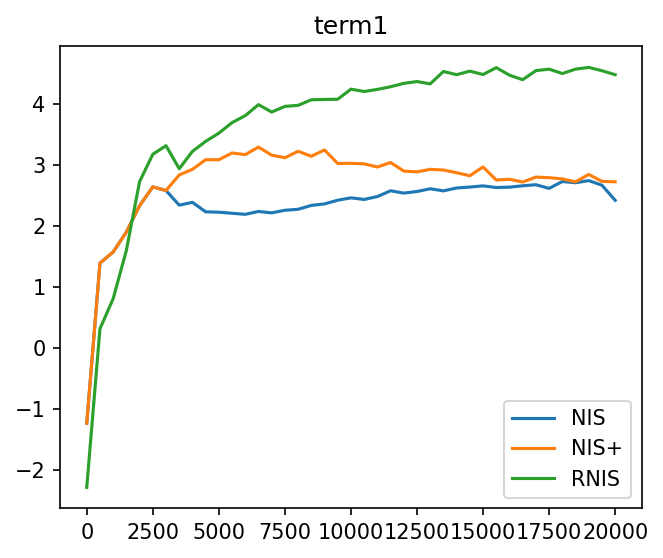

In [17]:
plt.figure(figsize=(5,4),dpi=150)
timeseries = np.arange(len(eis_nis)) * clip
plt.plot(timeseries, term1s_nis, label='NIS')
timeseries = np.arange(len(term1s_nisp)) * clip
plt.plot(timeseries, term1s_nisp, label='NIS+')
timeseries = np.arange(len(term1s_rnis)) * clip
plt.plot(timeseries, term1s_rnis, label='RNIS')
plt.title(r'term1')
plt.legend()
# plt.yscale('log')
plt.show()

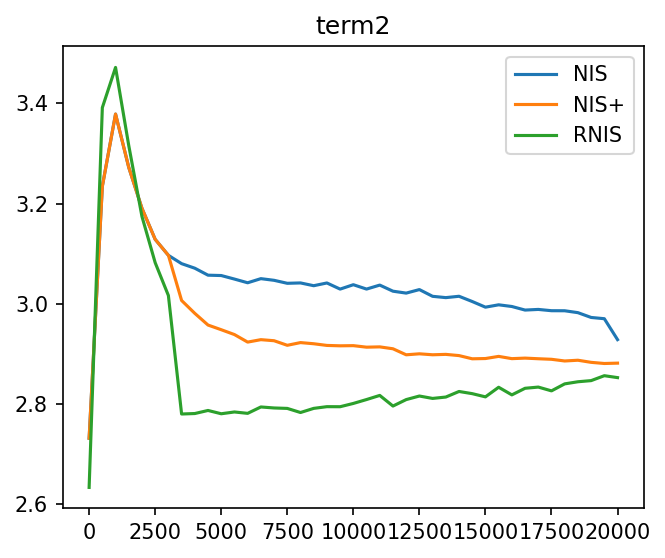

In [18]:
plt.figure(figsize=(5,4),dpi=150)
timeseries = np.arange(len(eis_nis)) * clip
plt.plot(timeseries, term2s_nis, label='NIS')
timeseries = np.arange(len(term1s_nisp)) * clip
plt.plot(timeseries, term2s_nisp, label='NIS+')
timeseries = np.arange(len(term2s_rnis)) * clip
plt.plot(timeseries, term2s_rnis, label='RNIS')
plt.title(r'term2')
plt.legend()
# plt.yscale('log')
plt.show()

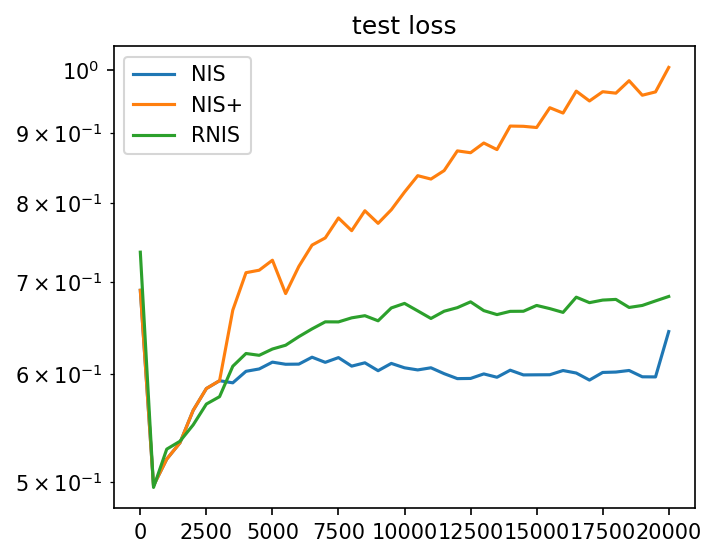

In [19]:
plt.figure(figsize=(5,4),dpi=150)
timeseries = np.arange(len(eis_nis)) * clip
plt.plot(timeseries, MAEs_mstep_nis, label='NIS')
timeseries = np.arange(len(MAEs_mstep_nisp)) * clip
plt.plot(timeseries, MAEs_mstep_nisp, label='NIS+')
timeseries = np.arange(len(MAEs_mstep_rnis)) * clip
plt.plot(timeseries, MAEs_mstep_rnis, label='RNIS')
plt.title(r'test loss')
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
mae2_w